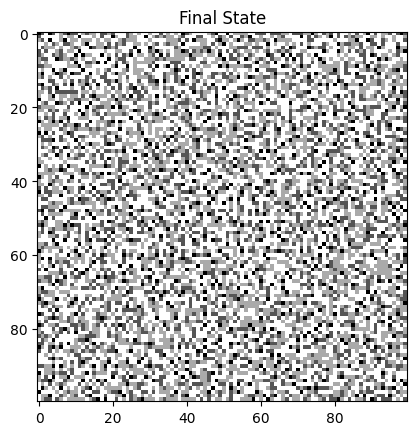

In [62]:
# Pavan SD HW1

import numpy as np
import matplotlib.pyplot as plt

class AbelianSandpile:
    def __init__(self, n=100, random_state=None):
        self.n = n
        np.random.seed(random_state)  # Set the random seed
        self.grid = np.random.choice([0, 1, 2, 3], size=(n, n))
        self.history = [self.grid.copy()]  # To track the history of the grid

    def step(self):
        # Randomly add a grain
        x, y = np.random.randint(0, self.n, 2)
        self.grid[x, y] += 1
        
        # Check for toppling and redistribute grains
        unstable = np.argwhere(self.grid >= 4)
        while len(unstable) > 0:
            for (i, j) in unstable:
                self.grid[i, j] -= 4
                if i > 0: self.grid[i-1, j] += 1
                if i < self.n - 1: self.grid[i+1, j] += 1
                if j > 0: self.grid[i, j-1] += 1
                if j < self.n - 1: self.grid[i, j+1] += 1
            unstable = np.argwhere(self.grid >= 4)
        
        self.history.append(self.grid.copy())

    def simulate(self, n_steps):
        for _ in range(n_steps):
            self.step()

# Initialize model and simulate
model = AbelianSandpile(n=100, random_state=42)
model.simulate(10000)

# Plot the final state
plt.imshow(model.grid, cmap='gray')
plt.title('Final State')
plt.show()


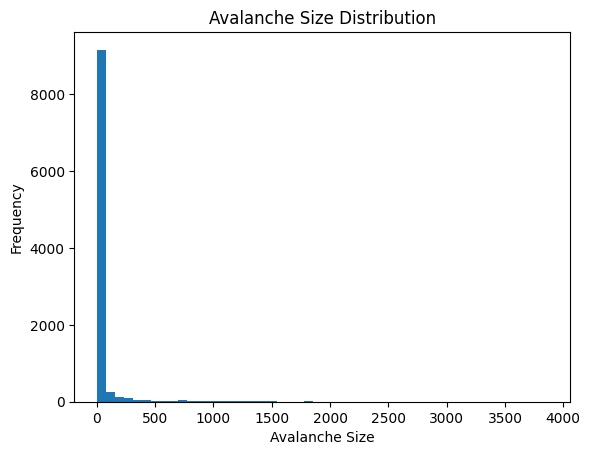

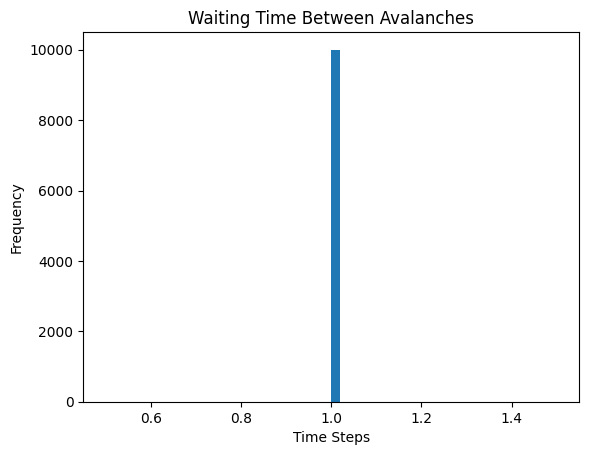

In [63]:
# Compute the pairwise difference between all observed snapshots to detect avalanches
all_events = [model.history[i] != model.history[i-1] for i in range(1, len(model.history))]
# Count how many cells changed state in each event
all_avalanche_sizes = [np.sum(event) for event in all_events]

# Plot the avalanche size distribution
plt.figure()
plt.hist(all_avalanche_sizes, bins=50)
plt.title('Avalanche Size Distribution')
plt.xlabel('Avalanche Size')
plt.ylabel('Frequency')
plt.show()

# Compute the waiting time between avalanches
all_avalanches = [i for i, size in enumerate(all_avalanche_sizes) if size > 0]
waiting_times = np.diff(all_avalanches)

# Plot the waiting time distribution
plt.figure()
plt.hist(waiting_times, bins=50)
plt.title('Waiting Time Between Avalanches')
plt.xlabel('Time Steps')
plt.ylabel('Frequency')
plt.show()


In [64]:
### Analysis

In [73]:
import numpy as np
import matplotlib.pyplot as plt

class PercolationSimulation:
    def __init__(self, n=100, p=0.9, random_state=None):
        self.n = n
        self.p = p
        np.random.seed(random_state)  # Set the random seed
        self.grid = np.random.rand(n, n) < p  # Initialize a grid with probability p of being open
        self.grid_filled = np.zeros_like(self.grid, dtype=bool)  # To track filled sites

    def _flow(self):
        # Fill from the top row
        self.grid_filled[0, :] = self.grid[0, :]
        for i in range(1, self.n):
            for j in range(self.n):
                # Fill if the current site is open and any of the neighbors above or the sides are filled
                self.grid_filled[i, j] = self.grid[i, j] and (
                    self.grid_filled[i-1, j] or 
                    (j > 0 and self.grid_filled[i, j-1]) or 
                    (j < self.n - 1 and self.grid_filled[i, j+1])
                )

    def percolate(self):
        self._flow()
        # Check if any site in the bottom row is filled
        if np.any(self.grid_filled[-1, :]):
            return True
        else:
            return False

    def simulate(self):
        if self.percolate():
            print("The system percolates.")
        else:
            print("The system does not percolate.")

# Example usage
n = 50  # Grid size
p = 0.6  # Probability of a site being open
simulation = PercolationSimulation(n, p)
simulation.simulate()


The system does not percolate.


In [66]:
def plot_grid(self):
    plt.figure(figsize=(10, 10))
    plt.imshow(self.grid_filled, cmap='Greys', interpolation='nearest')
    plt.title('Percolation Grid')
    plt.show()
